In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import numpy as np
import torch.utils.data as data
import librosa

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

### Importing the Data

In [2]:
from torchaudio.datasets import SPEECHCOMMANDS


In [3]:
import os

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

Load the data locally and create training and testing split of the data.

In [4]:
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform (the audio signal), the sample rate, the utterance (label), the ID of the speaker, the number of the utterance.

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


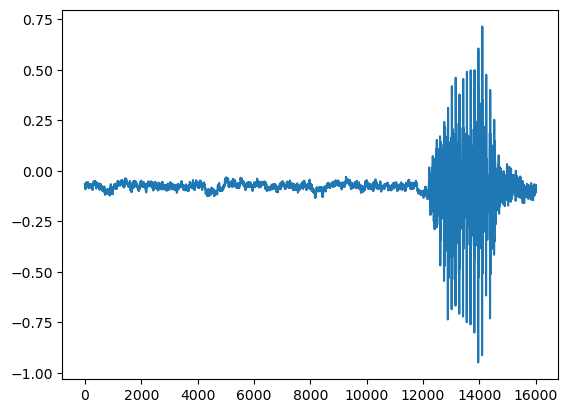

In [5]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())

### Formatting the Data

Downsample the audio for faster processing with the hope of not losing too much of the classification power.

In [8]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [9]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

To turn a list of data point made of audio recordings and utterances into two batched tensors for the model, we implement a collate function which is used by the PyTorch DataLoader that allows us to iterate over a dataset by batches. 

In [10]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

In [11]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))

In [12]:
def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

In [13]:
batch_size = 256
num_workers = 0
pin_memory = False

In [14]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [27]:
model = WaveNet(layer_size=10,
                stack_size=5,
                in_channels=256, 
                res_channels=512,
                lr=0.0002)

In [35]:
def infinite_batch(data):
        while True:
            for dataset in data:
                for inputs, targets in dataset:
                    yield inputs, targets

In [37]:

data = DataLoader(data_dir="/Users/lukesummers/Desktop/WaveNet/Files",
                  receptive_fields=model.receptive_fields,
                  sample_size=100000,
                  sample_rate=16000,
                  in_channels=256)

run(mod=model, data=data)

RuntimeError: Given groups=1, weight of size [512, 256, 2], expected input[1, 1, 21115] to have 256 channels, but got 1 channels instead

In [28]:
def run(data, targets):
        total_steps = 0
        mod = WaveNetModel(5, 10, 256)
        for inputs in data:
            loss = mod.loss(inputs, targets)

            total_steps += 1

            print('[{0}/{1}] loss: {2}'.format(total_steps, loss))

            if total_steps > 100000:
                break

        

In [33]:
def load_audio(filename, sample_rate=16000, trim=True, trim_frame_length=2048):
    audio, _ = librosa.load(filename, sr=sample_rate, mono=True)
    audio = audio.reshape(-1, 1)

    if trim > 0:
        audio, _ = librosa.effects.trim(audio, frame_length=trim_frame_length)

    return audio

def one_hot_decode(data, axis=1):
    decoded = np.argmax(data, axis=axis)

    return decoded


class Dataset(data.Dataset):
    def __init__(self, data_dir, sample_rate=16000, in_channels=256, trim=True):
        super(Dataset, self).__init__()

        self.in_channels = in_channels
        self.sample_rate = sample_rate
        self.trim = trim

        self.root_path = data_dir
        self.filenames = [x for x in sorted(os.listdir(data_dir))]

    def __getitem__(self, index):
        filepath = os.path.join(self.root_path, self.filenames[index])

        raw_audio = load_audio(filepath, self.sample_rate, self.trim)

        return raw_audio

    def __len__(self):
        return len(self.filenames)


class DataLoader(data.DataLoader):
    def __init__(self, data_dir, receptive_fields,
                 sample_size=0, sample_rate=16000, in_channels=256,
                 batch_size=1, shuffle=True):
        """
        DataLoader for WaveNet
        :param data_dir:
        :param receptive_fields: integer. size(length) of receptive fields
        :param sample_size: integer. number of timesteps to train at once.
                            sample size has to be bigger than receptive fields.
                            |-- receptive field --|---------------------|
                            |------- samples -------------------|
                            |---------------------|-- outputs --|
        :param sample_rate: sound sampling rates
        :param in_channels: number of input channels
        :param batch_size:
        :param shuffle:
        """
        dataset = Dataset(data_dir, sample_rate, in_channels)

        super(DataLoader, self).__init__(dataset, batch_size, shuffle)

        if sample_size <= receptive_fields:
            raise Exception("sample_size has to be bigger than receptive_fields")

        self.sample_size = sample_size
        self.receptive_fields = receptive_fields

        self.collate_fn = self._collate_fn

    def calc_sample_size(self, audio):
        return self.sample_size if len(audio[0]) >= self.sample_size\
                                else len(audio[0])

    @staticmethod
    def _variable(data):
        tensor = torch.from_numpy(data).float()

        if torch.cuda.is_available():
            return torch.autograd.Variable(tensor.cuda())
        else:
            return torch.autograd.Variable(tensor)

    def _collate_fn(self, audio):
        audio = np.pad(audio, [[0, 0], [self.receptive_fields, 0], [0, 0]], 'constant')

        if self.sample_size:
            sample_size = self.calc_sample_size(audio)

            while sample_size > self.receptive_fields:
                inputs = audio[:, :sample_size, :]
                targets = audio[:, self.receptive_fields:sample_size, :]

                yield self._variable(inputs),\
                      self._variable(one_hot_decode(targets, 2))

                audio = audio[:, sample_size-self.receptive_fields:, :]
                sample_size = self.calc_sample_size(audio)
        else:
            targets = audio[:, self.receptive_fields:, :]
            return self._variable(audio),\
                   self._variable(one_hot_decode(targets, 2))

In [15]:
class DilatedCausalConv1d(nn.Module):
    """Dilated Causal Convolution for WaveNet"""
    def __init__(self, channels, dilation=1):
        super(DilatedCausalConv1d, self).__init__()

        self.conv = nn.Conv1d(channels, channels,
                                    kernel_size=2, stride=1,
                                    dilation=dilation,
                                    padding=0, 
                                    bias=False)

    def init_weights_for_test(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                m.weight.data.fill_(1)

    def forward(self, x):
        output = self.conv(x)

        return output

class CausalConv1d(nn.Module):
    """Causal Convolution for WaveNet"""
    def __init__(self, in_channels, out_channels):
        super(CausalConv1d, self).__init__()

        # padding=1 for same size(length) between input and output for causal convolution
        self.conv = nn.Conv1d(in_channels, out_channels,
                                    kernel_size=2, stride=1, padding=1,
                                    bias=False)

    def init_weights_for_test(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv1d):
                m.weight.data.fill_(1)

    def forward(self, x):
        output = self.conv(x)

        # remove last value for causal convolution
        return output[:, :, :-1]

In [ ]:
class ResLayer(nn.module):
    def __init__(self, channels, dilation):
        super(ResLayer, self).__init__()
        self.dconv = nn.Conv1d(channels, channels,
                                    kernel_size=2, stride=1,
                                    dilation=dilation,
                                    padding=0, 
                                    bias=False)
        self.conv = nn.Conv1d(channels, channels, 1)

    def forward(self, x):
        out = self.dconv(x)
        tan = nn.Tanh(out)
        sig = nn.Sigmoid(out)
        gated = tan * sig
        return self.conv(gated)
        

In [ ]:
class WaveNetModel(nn.Module):
    def __init__(self, layers, layerSize, channels):
        super(WaveNetModel, self).__init__()
        dilations = []
        #build dilation numbers
        [[dilations.append(2**x) for x in range(layerSize)] for i in range(layers)]
        self.resLayers = []
        [self.resLayers.append(ResLayer(channels, d)) for d in dilations]
    def forward(self, x):
        output = x
        for layer in self.resLayers:
            output = layer(x)
        return output



In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, res_channels, skip_channels, dilation):
        """
        Residual block
        :param res_channels: number of residual channel for input, output
        :param skip_channels: number of skip channel for output
        :param dilation:
        """
        super(ResidualBlock, self).__init__()

        self.dilated = DilatedCausalConv1d(res_channels, dilation=dilation)
        self.conv_res = nn.Conv1d(res_channels, res_channels, 1)
        self.conv_skip = nn.Conv1d(res_channels, skip_channels, 1)

        self.gate_tanh = torch.nn.Tanh()
        self.gate_sigmoid = torch.nn.Sigmoid()

    def forward(self, x, skip_size):
        """
        :param x:
        :param skip_size: The last output size for loss and prediction
        :return:
        """
        output = self.dilated(x)

        # PixelCNN gate
        gated_tanh = self.gate_tanh(output)
        gated_sigmoid = self.gate_sigmoid(output)
        gated = gated_tanh * gated_sigmoid

        # Residual network
        output = self.conv_res(gated)
        input_cut = x[:, :, -output.size(2):]
        output += input_cut

        # Skip connection
        skip = self.conv_skip(gated)
        skip = skip[:, :, -skip_size:]

        return output, skip

In [17]:
class ResidualStack(nn.Module):
    def __init__(self, layer_size, stack_size, res_channels, skip_channels):
        """
        Stack residual blocks by layer and stack size
        :param layer_size: integer, 10 = layer[dilation=1, dilation=2, 4, 8, 16, 32, 64, 128, 256, 512]
        :param stack_size: integer, 5 = stack[layer1, layer2, layer3, layer4, layer5]
        :param res_channels: number of residual channel for input, output
        :param skip_channels: number of skip channel for output
        :return:
        """
        super(ResidualStack, self).__init__()

        self.layer_size = layer_size
        self.stack_size = stack_size

        self.res_blocks = self.stack_res_block(res_channels, skip_channels)

    @staticmethod
    def _residual_block(res_channels, skip_channels, dilation):
        block = ResidualBlock(res_channels, skip_channels, dilation)

        if torch.cuda.device_count() > 1:
            block = torch.nn.DataParallel(block)

        if torch.cuda.is_available():
            block.cuda()

        return block

    def build_dilations(self):
        dilations = []

        # 5 = stack[layer1, layer2, layer3, layer4, layer5]
        for s in range(0, self.stack_size):
            # 10 = layer[dilation=1, dilation=2, 4, 8, 16, 32, 64, 128, 256, 512]
            for l in range(0, self.layer_size):
                dilations.append(2 ** l)

        return dilations

    def stack_res_block(self, res_channels, skip_channels):
        """
        Prepare dilated convolution blocks by layer and stack size
        :return:
        """
        res_blocks = []
        dilations = self.build_dilations()

        for dilation in dilations:
            block = self._residual_block(res_channels, skip_channels, dilation)
            res_blocks.append(block)

        return res_blocks

    def forward(self, x, skip_size):
        """
        :param x:
        :param skip_size: The last output size for loss and prediction
        :return:
        """
        output = x
        skip_connections = []

        for res_block in self.res_blocks:
            # output is the next input
            output, skip = res_block(output, skip_size)
            skip_connections.append(skip)

        return torch.stack(skip_connections)

In [18]:
class DensNet(nn.Module):
    def __init__(self, channels):
        """
        The last network of WaveNet
        :param channels: number of channels for input and output
        :return:
        """
        super(DensNet, self).__init__()

        self.conv1 = nn.Conv1d(channels, channels, 1)
        self.conv2 = nn.Conv1d(channels, channels, 1)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        output = self.relu(x)
        output = self.conv1(output)
        output = self.relu(output)
        output = self.conv2(output)

        output = self.softmax(output)

        return output

In [26]:

class WaveNetModule(nn.Module):
    def __init__(self, layer_size, stack_size, in_channels, res_channels):
        """
        Stack residual blocks by layer and stack size
        :param layer_size: integer, 10 = layer[dilation=1, dilation=2, 4, 8, 16, 32, 64, 128, 256, 512]
        :param stack_size: integer, 5 = stack[layer1, layer2, layer3, layer4, layer5]
        :param in_channels: number of channels for input data. skip channel is same as input channel
        :param res_channels: number of residual channel for input, output
        :return:
        """
        super(WaveNetModule, self).__init__()

        self.receptive_fields = self.calc_receptive_fields(layer_size, stack_size)

        self.causal = CausalConv1d(in_channels, res_channels)

        self.res_stack = ResidualStack(layer_size, stack_size, res_channels, in_channels)

        self.densnet = DensNet(in_channels)

    @staticmethod
    def calc_receptive_fields(layer_size, stack_size):
        layers = [2 ** i for i in range(0, layer_size)] * stack_size
        num_receptive_fields = np.sum(layers)

        return int(num_receptive_fields)

    def calc_output_size(self, x):
        output_size = int(x.size(2)) - self.receptive_fields

        self.check_input_size(x, output_size)

        return output_size

    def check_input_size(self, x, output_size):
        if output_size < 1:
            raise InputSizeError(int(x.size(2)), self.receptive_fields, output_size)

    def forward(self, x):
        """
        The size of timestep(3rd dimention) has to be bigger than receptive fields
        :param x: Tensor[batch, timestep, channels]
        :return: Tensor[batch, timestep, channels]
        """
        output = x.transpose(1, 2)

        output_size = self.calc_output_size(output)

        output = self.causal(output)

        skip_connections = self.res_stack(output, output_size)

        output = torch.sum(skip_connections, dim=0)

        output = self.densnet(output)

        return output.transpose(1, 2).contiguous()

In [20]:

class WaveNet:
    def __init__(self, layer_size, stack_size, in_channels, res_channels, lr=0.002):

        self.net = WaveNetModule(layer_size, stack_size, in_channels, res_channels)

        self.in_channels = in_channels
        self.receptive_fields = self.net.receptive_fields

        self.lr = lr
        self.loss = self._loss()
        self.optimizer = self._optimizer()

        self._prepare_for_gpu()

    @staticmethod
    def _loss():
        loss = torch.nn.CrossEntropyLoss()

        if torch.cuda.is_available():
            loss = loss.cuda()

        return loss

    def _optimizer(self):
        return torch.optim.Adam(self.net.parameters(), lr=self.lr)

    def _prepare_for_gpu(self):
        if torch.cuda.device_count() > 1:
            print("{0} GPUs are detected.".format(torch.cuda.device_count()))
            self.net = torch.nn.DataParallel(self.net)

        if torch.cuda.is_available():
            self.net.cuda()

    def train(self, inputs, targets):
        """
        Train 1 time
        :param inputs: Tensor[batch, timestep, channels]
        :param targets: Torch tensor [batch, timestep, channels]
        :return: float loss
        """
        outputs = self.net(inputs)

        loss = self.loss(outputs.view(-1, self.in_channels),
                         targets.long().view(-1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.data[0]

    def generate(self, inputs):
        """
        Generate 1 time
        :param inputs: Tensor[batch, timestep, channels]
        :return: Tensor[batch, timestep, channels]
        """
        outputs = self.net(inputs)

        return outputs

    @staticmethod
    def get_model_path(model_dir, step=0):
        basename = 'wavenet'

        if step:
            return os.path.join(model_dir, '{0}_{1}.pkl'.format(basename, step))
        else:
            return os.path.join(model_dir, '{0}.pkl'.format(basename))

    def load(self, model_dir, step=0):
        """
        Load pre-trained model
        :param model_dir:
        :param step:
        :return:
        """
        print("Loading model from {0}".format(model_dir))

        model_path = self.get_model_path(model_dir, step)

        self.net.load_state_dict(torch.load(model_path))

    def save(self, model_dir, step=0):
        print("Saving model into {0}".format(model_dir))

        model_path = self.get_model_path(model_dir, step)

        torch.save(self.net.state_dict(), model_path)

In [30]:
class InputSizeError(Exception):
    def __init__(self, input_size, receptive_fields, output_size):

        message = 'Input size has to be larger than receptive_fields\n'
        message += 'Input size: {0}, Receptive fields size: {1}, Output size: {2}'.format(
            input_size, receptive_fields, output_size)

        super(InputSizeError, self).__init__(message)